In [1]:
!pip install -r https://raw.githubusercontent.com/malkiAbdelhamid/Advanced-Deep-Learning-2024-2025-esisba/master/lab1_QLearning/requirements_lab1.txt

In [2]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import imageio

In [3]:
class SARSA_Agent:

    def __init__(self, env, alpha, gamma, max_epsilon, min_epsilon, decay_rate):

        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table=np.zeros((env.observation_space.n, env.action_space.n))

        # hyper-parameters
        self.alpha = alpha                      # learning rate
        self.gamma = gamma                      # discount factor
        self.max_epsilon = max_epsilon          # Exploration probability at start
        self.min_epsilon = min_epsilon          # Minimum exploration probability
        self.decay_rate =  decay_rate           # Exponential decay rate for exploration prob



    # get action using epsilon greedy polic
    def get_action(self, state, epsilon):
        # Randomly generate a number between 0 and 1
        random_num =random.uniform(0,1)

        # if random_num > greater than epsilon --> exploitation
        if random_num > epsilon:
           # Take the action with the highest value given a state
           # np.argmax can be useful here
           action = np.argmax(self.q_table[state])

        # else --> exploration
        else:
           action = self.env.action_space.sample()

        return action

    def update_parameters(self, state, action, reward, next_state,epsilon):
        """"""
        # SARSA-learning formula
        # Update Q(s,a):= Q(s,a) + lr [R(s,a)  + gamma * Q(s',a') - Q(s,a)]
         #--- add code here (4 lines)----------
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[state])
        new_value = old_value + self.alpha * (reward + gamma * next_max - old_value)
        # update the q_table
        self.q_table[state, action] = new_value

In [4]:
def train(n_training_episodes, max_steps, env, agent):

  episode_rewards = []
  episode_penalties = []
  episode_steps = []
  for episode in tqdm(range(n_training_episodes)):

    total_rewards_ep = 0
    total_penalties_ep=0
    total_steps_ep=0

    # Reduce epsilon (because we need less and less exploration)
    epsilon = agent.min_epsilon + (agent.max_epsilon - agent.min_epsilon)*np.exp(-agent.decay_rate*episode)

    # Reset the environment
    state, info = env.reset()
    step = 0
    terminated = False
    truncated = False
    done=False

    # repeat
    while not done:
      # Choose the action At using epsilon greedy policy
      action = agent.get_action(state, epsilon)

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      next_state, reward, terminated, truncated, info = env.step(action)

      total_rewards_ep += reward
      total_steps_ep +=1
      if reward == -10:
            total_penalties_ep += 1

      # Update Q(s,a):= Q(s,a) + lr [R(s,a)  + gamma * Q(s',a') - Q(s,a)]
      agent.update_parameters(state, action, reward, next_state, epsilon)
      # If terminated or truncated finish the episode
      done=terminated or truncated

      if done:
        break

      # Our next state is the new state
      state = next_state

      episode_rewards.append(total_rewards_ep)
      episode_steps.append(total_steps_ep)
      episode_penalties.append(total_penalties_ep)

  return  episode_rewards,episode_steps, episode_penalties


In [5]:
# Training parameters
n_training_episodes = 1000  # Total training episodes
alpha= 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005            # Exponential decay rate for exploration prob

In [6]:
#env=gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")
env=gym.make("Taxi-v3", render_mode="rgb_array")

agent=SARSA_Agent(env, alpha, gamma, max_epsilon, min_epsilon, decay_rate)

episode_rewards,episode_steps, episode_penalties=train(n_training_episodes, max_steps, env,agent)

100%|██████████| 1000/1000 [00:10<00:00, 92.09it/s]


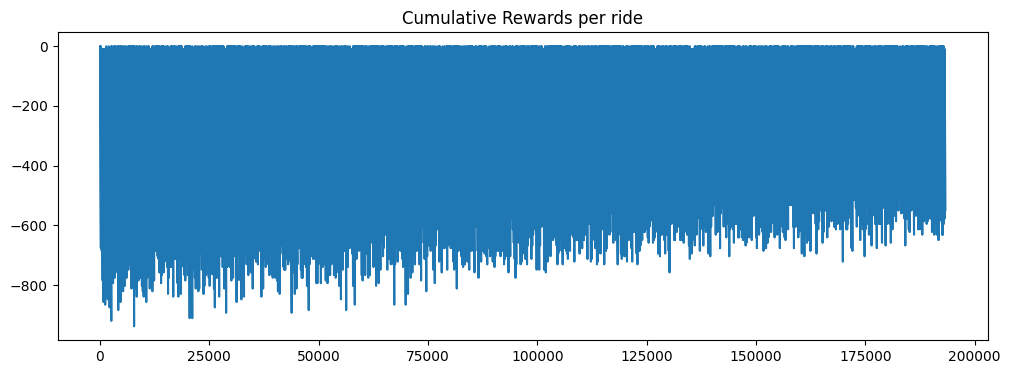

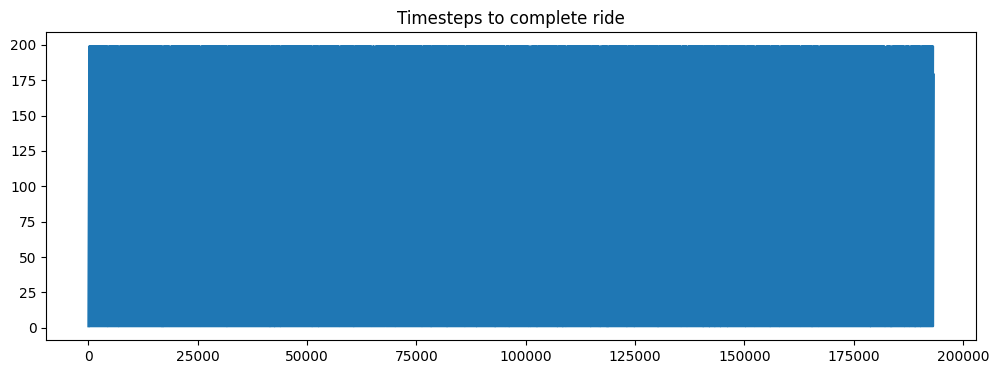

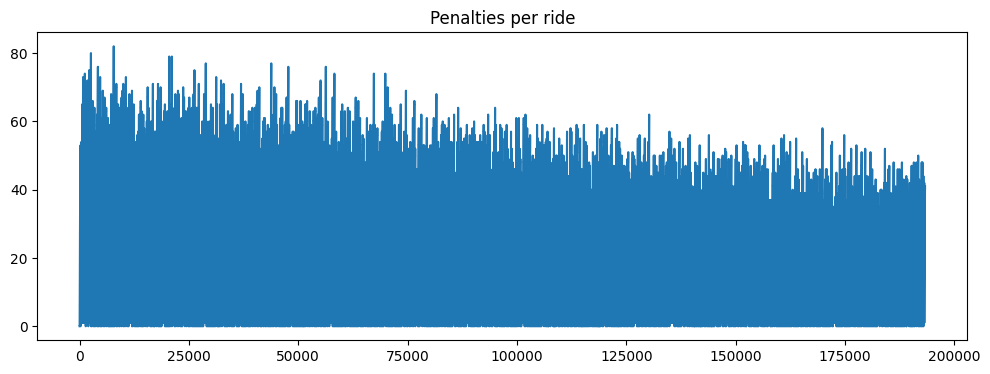

In [7]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Cumulative Rewards per ride")
pd.Series(episode_rewards).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")
pd.Series(episode_steps).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")
pd.Series(episode_penalties).plot(kind='line')
plt.show()

### Evaluate the QAgent after training

In [8]:
def evaluate_agent(env,agent,  n_eval_episodes):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param agent: the gent within its  evaluation environment and Qtable
  :param max_steps: Maximum number of steps per episode
  :param n_eval_episodes: Number of episode to evaluate the agent
   """
  episode_rewards = []
  episode_penalties = []
  episode_steps = []
  for episode in tqdm(range(n_eval_episodes)):

    state, info= env.reset()
    step = 0
    truncated = False
    terminated = False
    total_rewards_ep = 0
    total_penalties_ep=0
    total_steps_ep=0
    done= False

    while not done:
      # Take the action (index) that have the maximum expected future reward given that state
      # we use epsilon=0 for exploitation

      action = agent.get_action(state,0)
      next_state, reward, terminated, truncated, info = env.step(action)

      total_rewards_ep += reward
      total_steps_ep+=1

      if reward == -10:
            total_penalties_ep += 1

      done=terminated or truncated

      if done:
        break

      state = next_state

    episode_rewards.append(total_rewards_ep)
    episode_steps.append(total_steps_ep)
    episode_penalties.append(total_penalties_ep)

  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward, episode_rewards,episode_steps, episode_penalties

In [9]:
mean_reward, std_reward,episode_rewards,episode_steps, episode_penalties=evaluate_agent(env,agent, 1000)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

100%|██████████| 1000/1000 [00:08<00:00, 121.47it/s]

Mean_reward=-200.00 +/- 0.00


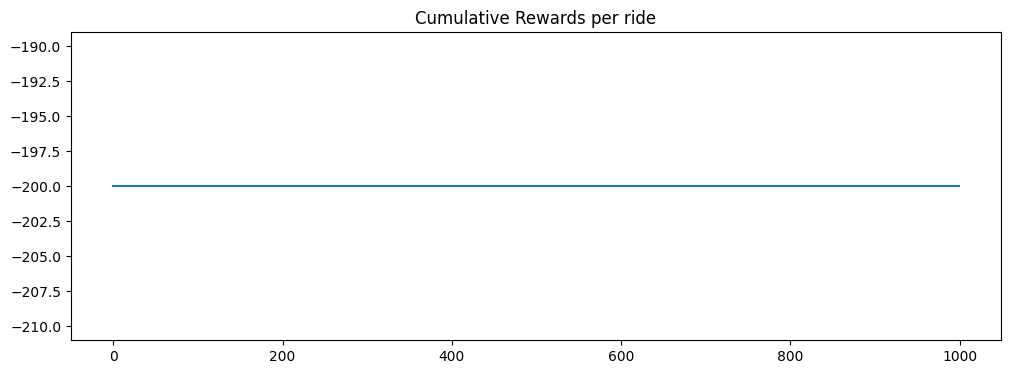

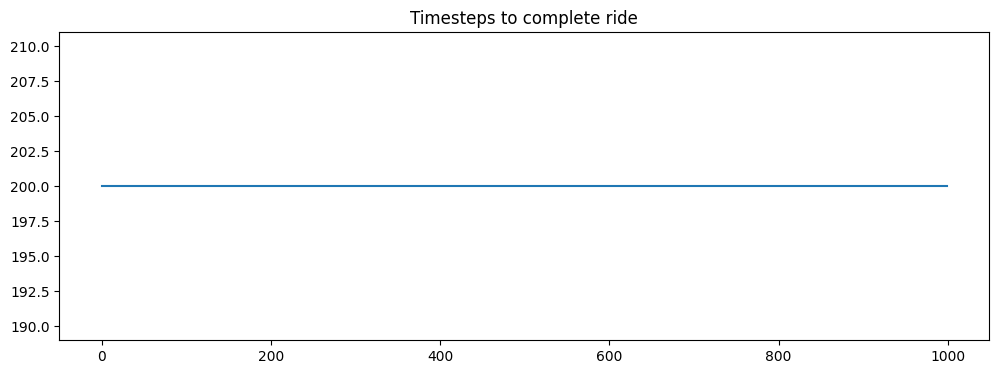

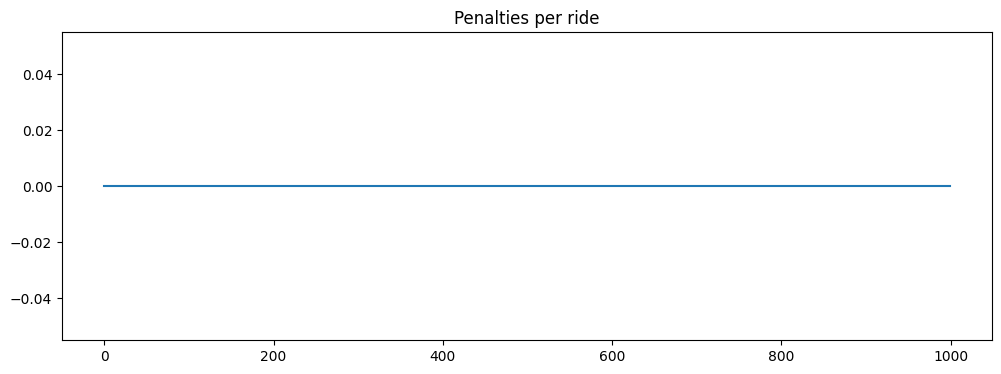

In [10]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Cumulative Rewards per ride")
pd.Series(episode_rewards).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")
pd.Series(episode_steps).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")
pd.Series(episode_penalties).plot(kind='line')
plt.show()

### Record a simulation as a video

In [11]:
def record_video(env, agent, out_directory, fps=1):
  """
  Generate a replay video of the agent
  :param env
  :param agent:  agent within its Qtable
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """
  images = []
  terminated = False
  truncated = False
  state, info = env.reset(seed=random.randint(0,500))
  img = env.render()
  images.append(img)
  while not terminated or truncated:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(agent.q_table[state][:])
    state, reward, terminated, truncated, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [ ]:

from base64 import b64encode
from IPython.display import HTML

# generate the video
video_path = "./replay.mp4"
record_video(env, agent, video_path, 1)

# Show video
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""<video width=400 controls>      <source src="%s" type="video/mp4"></video>""" % data_url)

error: XDG_RUNTIME_DIR not set in the environment.
